In [1]:
# Sample API
import mae6225
#import simulation
mae6225.__version__

'0.1.dev'

In [2]:
# Define grid parameters
nx, ny = 40, 40
xmin, xmax = 0.0, 1.0
ymin, ymax = 0.0, 1.0

Re   = 100.0
dt   = 0.01
tmax = 10.

# Define cell-centered variable names
center_vars = ['pres', 'divp', 'divc','asol','eror']
face_vars   = ['velc', 'hvar','asol','eror']

# Define boundary conditions for variable pressure and velocity [left, right, bottom, top]
bc_type_pres = {'pres': ['neumann', 'neumann', 'neumann', 'neumann']}
bc_val_pres  = {'pres': [0.0, 0.0, 0.0, 0.0]}

bc_type_u = {'velc': ['dirichlet', 'dirichlet', 'dirichlet', 'dirichlet']}
bc_val_u  = {'velc': [0.0, 0.0, 0.0, 1.0]}

bc_type_v = {'velc': ['dirichlet', 'dirichlet', 'dirichlet', 'dirichlet']}
bc_val_v  = {'velc': [0.0, 0.0, 0.0, 0.0]}


# Create the grid and data
gridc = mae6225.Grid('cell-centered', center_vars,
                    nx, ny, xmin, xmax, ymin, ymax,
                    user_bc_type=bc_type_pres, user_bc_val=bc_val_pres)

gridx = mae6225.Grid('x-face', face_vars,
                    nx, ny, xmin, xmax, ymin, ymax,
                    user_bc_type=bc_type_u, user_bc_val=bc_val_u)

gridy = mae6225.Grid('y-face', face_vars,
                    nx, ny, xmin, xmax, ymin, ymax,
                    user_bc_type=bc_type_v, user_bc_val=bc_val_v)

In [3]:
t  = 0.0
nt = 0

ins_stats = dict()

while t <= tmax:
    
    # Calculate predicted velocity: u* = dt*H(u^n)
    mae6225.ins.predictor(gridx, gridy, 'velc', 'hvar', Re, dt)
    
    # Calculate RHS for the pressure Poission solver div(u)/dt
    mae6225.ins.divergence(gridc, gridx, gridy, 'velc', 'divp', ifac=dt)
    
    # Solve the pressure Poisson equation 
    ins_stats['ites'], ins_stats['res'] = mae6225.poisson.solve_jacobi(gridc, 'pres', 'divp',
                                                                       maxiter=10000, tol=1e-9)
    
    # Calculate corrected velocity u^n+1 = u* - dt * grad(P) 
    mae6225.ins.corrector(gridc, gridx, gridy, 'velc', 'pres', dt)
    
    # Calculate divergence of the corrected velocity to display stats
    mae6225.ins.divergence(gridc, gridx, gridy, 'velc', 'divc')
    
    # Calculate stats
    ins_stats.update(mae6225.ins.stats(gridc, gridx, gridy, 'velc', 'pres', 'divc'))
    
    # Display stats
    if nt % 10 == 0:
        mae6225.io.display_stats(t, ins_stats)   
    
    t += dt
    nt += 1
    

------------ Time = 0.0 ---------------
Number of poisson iterations    : 1
Final poisson residual : 0.0
Max, Min, U   : 2.0, 0.0
Max, Min, V   : 0.0, 0.0
Max, Min, P   : 0.0, 0.0
Max, Min, DIV : 0.0, 0.0


------------ Time = 0.09999999999999999 ---------------
Number of poisson iterations    : 5538
Final poisson residual : 9.98778261744523e-10
Max, Min, U   : 2.0, -0.1276021295378761
Max, Min, V   : 0.29587932179126736, -0.3038712901239007
Max, Min, P   : 1.2094198143214747, -0.8703529014661785
Max, Min, DIV : 8.958161501482209e-08, -8.95165846843092e-08


------------ Time = 0.20000000000000004 ---------------
Number of poisson iterations    : 4765
Final poisson residual : 9.98887455683559e-10
Max, Min, U   : 2.0, -0.14215177739944862
Max, Min, V   : 0.3254680445370629, -0.3762157290232419
Max, Min, P   : 1.2229836202495217, -0.7778045378343613
Max, Min, DIV : 9.060888039869042e-08, -9.040188229947344e-08


------------ Time = 0.3000000000000001 ---------------
Number of poisson ite

------------ Time = 2.399999999999993 ---------------
Number of poisson iterations    : 1667
Final poisson residual : 9.987001326578525e-10
Max, Min, U   : 2.0, -0.1716341684832096
Max, Min, V   : 0.3402418266581903, -0.4762251534144684
Max, Min, P   : 1.3767346623085261, -0.6958427489367028
Max, Min, DIV : 1.0064518487932009e-07, -1.0623859303393601e-07


------------ Time = 2.4999999999999907 ---------------
Number of poisson iterations    : 1609
Final poisson residual : 9.988485159955212e-10
Max, Min, U   : 2.0, -0.17063673860108652
Max, Min, V   : 0.340235591059172, -0.47630507535543837
Max, Min, P   : 1.3772951798553072, -0.6958661179302694
Max, Min, DIV : 9.610445793860334e-08, -1.1262091703656552e-07


------------ Time = 2.5999999999999885 ---------------
Number of poisson iterations    : 1549
Final poisson residual : 9.999307503311178e-10
Max, Min, U   : 2.0, -0.16967069071137358
Max, Min, V   : 0.34023031869330655, -0.4763641881530908
Max, Min, P   : 1.3777680593727342, -0.69

------------ Time = 4.699999999999944 ---------------
Number of poisson iterations    : 454
Final poisson residual : 9.983634955229945e-10
Max, Min, U   : 2.0, -0.16029396051065026
Max, Min, V   : 0.3402034522043037, -0.47661943552524355
Max, Min, P   : 1.3807058267487113, -0.6961243809331166
Max, Min, DIV : 6.059518331547054e-08, -2.0106549136755802e-07


------------ Time = 4.799999999999942 ---------------
Number of poisson iterations    : 429
Final poisson residual : 9.976563048277531e-10
Max, Min, U   : 2.0, -0.1601425970314108
Max, Min, V   : 0.34020332076453735, -0.47662614002743053
Max, Min, P   : 1.3807454613500993, -0.6961260767110925
Max, Min, DIV : 6.247084821664473e-08, -2.041771693939154e-07


------------ Time = 4.89999999999994 ---------------
Number of poisson iterations    : 406
Final poisson residual : 9.984143745468117e-10
Max, Min, U   : 2.0, -0.16000311614001733
Max, Min, V   : 0.3402032058394778, -0.4766326806181219
Max, Min, P   : 1.3807825105733258, -0.69612747

------------ Time = 6.999999999999895 ---------------
Number of poisson iterations    : 175
Final poisson residual : 9.97402993380855e-10
Max, Min, U   : 2.0, -0.15860402274934932
Max, Min, V   : 0.3402023433046908, -0.47672457230325227
Max, Min, P   : 1.3812040452911452, -0.6961270427692845
Max, Min, DIV : 8.438409715427753e-08, -2.2107467323451147e-07


------------ Time = 7.099999999999893 ---------------
Number of poisson iterations    : 169
Final poisson residual : 9.943540267386745e-10
Max, Min, U   : 2.0, -0.15857668613199952
Max, Min, V   : 0.3402023309791131, -0.4767270453307709
Max, Min, P   : 1.3812138364105997, -0.6961265868849847
Max, Min, DIV : 8.559703784660755e-08, -2.207937690457129e-07


------------ Time = 7.199999999999891 ---------------
Number of poisson iterations    : 163
Final poisson residual : 9.968610685349054e-10
Max, Min, U   : 2.0, -0.1585511728269791
Max, Min, V   : 0.3402023195472409, -0.476729388484986
Max, Min, P   : 1.3812230665469807, -0.69612613455

------------ Time = 9.399999999999844 ---------------
Number of poisson iterations    : 64
Final poisson residual : 9.997629131109762e-10
Max, Min, U   : 2.0, -0.15826820866908567
Max, Min, V   : 0.3402021944519712, -0.47675793906845254
Max, Min, P   : 1.3813326434271933, -0.6961190901860848
Max, Min, DIV : 1.1188499191017165e-07, -2.1510074077468744e-07


------------ Time = 9.499999999999842 ---------------
Number of poisson iterations    : 61
Final poisson residual : 9.990103271058134e-10
Max, Min, U   : 2.0, -0.1582626745033064
Max, Min, V   : 0.3402021918754877, -0.47675854617531976
Max, Min, P   : 1.3813349350074777, -0.6961189129566154
Max, Min, DIV : 1.1249620124331727e-07, -2.1368076197347818e-07


------------ Time = 9.59999999999984 ---------------
Number of poisson iterations    : 59
Final poisson residual : 9.92039009003396e-10
Max, Min, U   : 2.0, -0.15825748729499506
Max, Min, V   : 0.34020218947761854, -0.4767591166895216
Max, Min, P   : 1.3813370911736589, -0.696118745

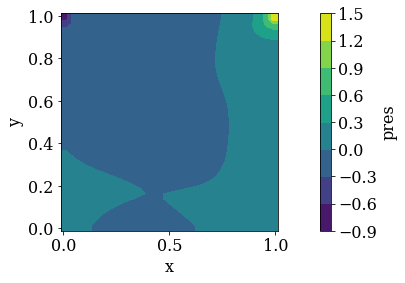

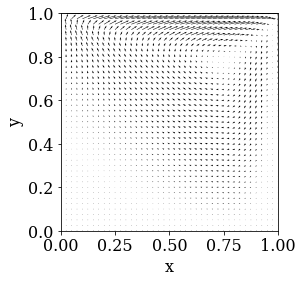

In [4]:
# Plot the analytical solution
mae6225.io.plot_contour(gridc, 'pres')
mae6225.io.plot_vector(gridx,gridy,'velc')